In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import numpy as np
import torch
import  torch.nn as nn
import torch.nn.functional as F
rseed = 42
np.random.seed(rseed)
torch.manual_seed(rseed)
gpu_id = '3'
import joblib
from joblib import Parallel, delayed
os.environ['CUDA_VISIBLE_DEVICES']=gpu_id
os.environ['JOBLIB_TEMP_FOLDER'] = '/ksozykinraid/data/tmp/'
import torch 
import pandas as pd
import glob2
import json
from ipypb import ipb
from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Datasets

In [2]:
data_root = '/ksozykinraid/data/sensors/'
data_fnzip =  "%s/%s" % (data_root , 'PAMAP2_Dataset.zip')
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip'

In [3]:
if not os.path.exists(data_fnzip[:-4]):
    !curl -L $data_url -o $data_fnzip
    !unzip $data_fnzip -d $data_root

In [4]:
path2subjets = sorted(glob2.glob('%s/PAMAP2_Dataset/Protocol/*.dat' % data_root))

In [5]:
def pamap_columns():
    """
        https://github.com/NLeSC/mcfly-tutorial/blob/master/utils/tutorial_pamap2.py
    """
    axes = ['x', 'y', 'z']
    IMUsensor_columns = ['temperature'] + \
        ['acc_16g_' + i for i in axes] + \
        ['acc_6g_' + i for i in axes] + \
        ['gyroscope_' + i for i in axes] + \
        ['magnometer_' + i for i in axes] + \
        ['orientation_' + str(i) for i in range(4)]
    columns = ["timestamp", "activityID", "heartrate"] + ["hand_" + s
                                                         for s in IMUsensor_columns] \
        + ["chest_" + s for s in IMUsensor_columns] + ["ankle_" + s
                                                       for s in IMUsensor_columns]
    return columns

In [6]:
demo_activities = "lying,sitting,standing,walking".split(',')

In [7]:
num2label = {1: 'lying',
               2: 'sitting',
               3: 'standing',
               4: 'walking',
               5: 'running',
               6: 'cycling',
               7: 'Nordic walking',
               9: 'watching TV',
               10: 'computer work',
               11: 'car driving',
               12: 'ascending stairs',
               13: 'descending stairs',
               16: 'vacuum cleaning',
               17: 'ironing',
               18: 'folding laundry',
               19: 'house cleaning',
               20: 'playing soccer',
               24: 'rope jumping',
                0: 'other'}

label2num = {'lying': 1,
 'sitting': 2,
 'standing': 3,
 'walking': 4,
 'running': 5,
 'cycling': 6,
 'Nordic walking': 7,
 'watching TV': 9,
 'computer work': 10,
 'car driving': 11,
 'ascending stairs': 12,
 'descending stairs': 13,
 'vacuum cleaning': 16,
 'ironing': 17,
 'folding laundry': 18,
 'house cleaning': 19,
 'playing soccer': 20,
 'rope jumping': 24,
 'other': 0}

In [8]:
all_columns = pamap_columns()

In [9]:
data_columns = [ 
 'hand_acc_16g_x',
 'hand_acc_16g_y',
 'hand_acc_16g_z',
 'hand_gyroscope_x',
 'hand_gyroscope_y',
 'hand_gyroscope_z',
 'hand_magnometer_x',
 'hand_magnometer_y',
 'hand_magnometer_z',

 'chest_acc_16g_x',
 'chest_acc_16g_y',
 'chest_acc_16g_z',
 'chest_gyroscope_x',
 'chest_gyroscope_y',
 'chest_gyroscope_z',
 'chest_magnometer_x',
 'chest_magnometer_y',
 'chest_magnometer_z',


 'ankle_acc_16g_x',
 'ankle_acc_16g_y',
 'ankle_acc_16g_z',
 'ankle_gyroscope_x',
 'ankle_gyroscope_y',
 'ankle_gyroscope_z',
 'ankle_magnometer_x',
 'ankle_magnometer_y',
 'ankle_magnometer_z',
]

In [10]:
input_channels = len(data_columns)

In [11]:
input_channels

27

In [12]:
useful_colums =  data_columns  + ['activityID']

In [13]:
# np.min([len(s) for s in subjects])
min_len = 93620

In [14]:
demo_mode = False

In [15]:
subjects = []
n_subjects = len(path2subjets)
for i in ipb(n_subjects):
    subject = pd.read_csv(path2subjets[i],header=None,sep=' ')
    subject.columns = pamap_columns()
    if demo_mode:
        subject = subject[subject['activityID'].isin([label2num[a] for a in demo_activities])]
        subject['activityID'] = subject['activityID'] - 1
    subject = subject[useful_colums]
    if len(subject) > 0:
        subject = subject.fillna(0)
        #subject = subject.iloc[:min_len]
        subjects.append(subject)

 [████████████████████████████████████████████████████████████] 9/9 [00:18<00:00, 2.03s/it]

In [16]:
np.unique(subjects[4]["activityID"])

array([ 0,  1,  2,  3,  4,  5,  6,  7, 12, 13, 16, 17, 24])

In [17]:
import torch.utils.data

In [18]:
def sliding_window(sequence,win_size = 20,step=5):
    # Pre-compute number of chunks to emit
    nb_chunks = ((len(sequence)-win_size)//step)+1
    # Do the work
    for i in range(0,nb_chunks*step,step):
        yield sequence[i:i+win_size]

In [19]:
def major_filter(activity):
    unique, counts = np.unique(activity, return_counts=True)
    return unique[np.argmax(counts)]

In [20]:
def one_hot(a, num_classes = 4):
    a = a.astype('int32') - 1
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
label2num.keys()

dict_keys(['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'watching TV', 'computer work', 'car driving', 'ascending stairs', 'descending stairs', 'vacuum cleaning', 'ironing', 'folding laundry', 'house cleaning', 'playing soccer', 'rope jumping', 'other'])

In [23]:
if demo_mode:
    num_classes = 4
else:
    num_classes = max([int(e) for e in num2label.keys() ]) + 1

In [24]:
num_classes

25

In [25]:
class acivityDataset(torch.utils.data.Dataset):
    
    """
        
    """
    def __init__(self,subjects,evaluate=False,
                 win_size=256,step=128,
                 num_classes = 4,
                 val_rate = 0.3):
        """
        """
        self.data = []
        self.labels = []
        self.win_size = win_size
        self.step = step
        
        self.evaluate = evaluate
        
        
        for i in ipb(range(len(subjects))):
            data = []
            labels = []
            subject = subjects[i]
            for window in sliding_window(subject[useful_colums],win_size = self.win_size,
                                         step=self.step):
                self.data.append(window[data_columns])
                self.labels.append(major_filter(window['activityID']))
        self.data = np.vstack(self.data)
        self.data = self.data.reshape([-1,self.win_size,len(data_columns)]).astype('float32')
        self.labels = np.hstack(self.labels)
        
        self.labels = one_hot(self.labels,num_classes).astype('float32')
        
        self.total_size = len(self.data)
        
        indxs = train_test_split(np.arange(self.total_size),test_size=val_rate,random_state=rseed)
        self.train_idxs = indxs[0]
        self.val_idxs = indxs[1]
        
        #self.val_rate = val_rate
        #self.val_size = int(self.val_rate*self.total_size)

        #self.train_rate = 1-self.val_rate
        #self.train_size = int(self.train_rate*self.total_size)
        
        self.train_data = self.data[self.train_idxs]
        self.train_labels = self.labels[self.train_idxs]
        self.val_data = self.data[self.val_idxs]
        self.val_labels = self.labels[self.val_idxs]
        
        
    def __len__(self,):
        """
        """
        if not self.evaluate:
            return len(self.train_data)
        else:
            return len(self.val_data)
            
    
    def __getitem__(self, index):
        """
        """
        if not self.evaluate:
            data = self.train_data[index]
            label =  self.train_labels[index]
        else:
            data = self.val_data[index]
            label =  self.val_labels[index]
        
        return data,label

In [26]:
win_size = 256
step = 128

In [27]:
train_dataset = acivityDataset(subjects,evaluate=False,win_size=win_size,step=step,num_classes=num_classes)
val_dataset = acivityDataset(subjects,evaluate=True,num_classes=num_classes)


 [████████████████████████████████████████████████████████████] 9/9 [00:18<00:00, 2.00s/it]

 [████████████████████████████████████████████████████████████] 9/9 [00:17<00:00, 1.93s/it]

In [28]:
train_lb = np.argmax(train_dataset.labels[train_dataset.train_idxs],-1)
val_lb = np.argmax(val_dataset.labels[val_dataset.val_idxs],-1)

(array([3084., 1859., 1929.,    0.,  638.,  570., 2278.,    0.,    0.,
        5340.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

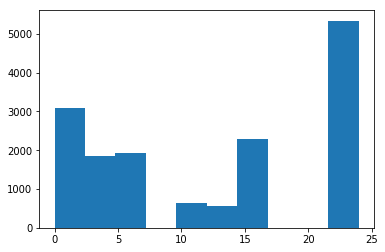

In [29]:
plt.hist(train_lb)

(array([1349.,  770.,  828.,    0.,  279.,  250.,  960.,    0.,    0.,
        2293.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

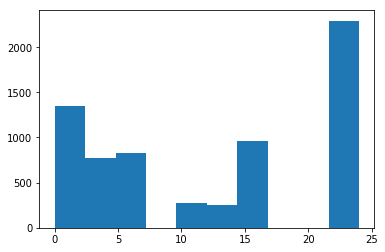

In [30]:
plt.hist(val_lb)

# Models

In [31]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [32]:
"""
     extention of the https://github.com/mravanelli/SincNet
"""

class Flip(nn.Module):
    
    def __init__(self,dim):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self,x):
        xsize = x.size()
        dim = x.dim() + dim if self.dim < 0 else self.dim
        x = x.contiguous()
        x = x.view(-1, *xsize[dim:])
        x = x.view(x.size(0), x.size(1), -1)[:, torch.arange(x.size(1)-1, -1, -1), :]
        return x.view(xsize)


class Sinc(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.flip = Flip(0)
        
    def forward(self,band,t_right):
        y_right= torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
        y_left = self.flip(y_right)
        y = torch.cat([y_left,torch.ones(1).to(device),y_right])
        return y

In [33]:
class multichannel_sinc_conv(nn.Module):
    """
     extention of the https://github.com/mravanelli/SincNet
    """
    def __freqinit__(self):
        if self.cutfreq_type == 'mel':
            low_freq_mel = 80
            high_freq_mel = (2595 * np.log10(1 + (self.fs / 2) / 700))  # Convert Hz to Mel
            mel_points = np.linspace(low_freq_mel, high_freq_mel, self.N_filt)  # Equally spaced in Mel scale
            f_cos = (700 * (10**(mel_points / 2595) - 1)) # Convert Mel to Hz
            b1=np.roll(f_cos,1)
            b2=np.roll(f_cos,-1)
            b1[0] = 30
            b2[-1] = (self.fs/2)-100
        elif self.cutfreq_type == 'pre_defined':
            b1 = np.array([15,35,80])
            b2 = np.array([25,50,90])
        elif self.cutfreq_type == 'random':
            eeg_const = 100
            b1 = np.random.randint(10,int(self.fs//2)-10,[self.N_filt])
            #b1 = 10 * np.ones([self.N_filt])
            b2 = np.minimum(b1+5,int(self.fs//2))        
            b1 = b1.tolist()
            b2 = b2.tolist()
        else:
            raise NotImplementedError
        bands_low = []
        bands_high = []
        for i in range(self.N_channels):
            bands_low.append(b1)
            bands_high.append(b2)
        bands_low = np.array(bands_low).astype('float32')
        bands_high = np.array(bands_high).astype('float32')
        return (bands_low,bands_high)

    def get_filter_bank(self,beg_freq,end_freq):
        if self.filt_type == 'sinc':
            t_right = (torch.linspace(1, (self.Filt_dim-1)/2, steps=int((self.Filt_dim-1)/2))/self.fs).to(device)
            low_pass1 = 2*beg_freq.float()*self.sinc(beg_freq.float()*self.fs,t_right)
            low_pass2 = 2*end_freq.float()*self.sinc(end_freq.float()*self.fs,t_right)
            band_pass = (low_pass2-low_pass1)
            band_pass = band_pass/torch.max(band_pass)
            return band_pass.to(device)*self.window
        elif self.filt_type == 'firwin':
            cut1 = beg_freq.float().detach().cpu().numpy()*self.fs
            cut2 = end_freq.float().detach().cpu().numpy()*self.fs
            cut1 = np.round(cut1)
            cut2 = np.round(cut2)
            band_pass = sp.signal.firwin(self.Filt_dim, [cut1,cut2], pass_zero=False,fs=self.fs,window='hamming')
            band_pass = torch.from_numpy(band_pass.astype('float32'))
            band_pass = nn.Parameter(band_pass.to(device))
            return band_pass
        else:
            raise NotImplementedError

    def __init__(self, 
                 N_filt, N_channels, Filt_dim, fs,
                 cutfreq_type = 'mel', filt_type = 'sinc'):
        super(multichannel_sinc_conv,self).__init__()
        self.cutfreq_type = cutfreq_type
        self.fs = float(fs)
        self.sinc = Sinc()
        self.filt_type = filt_type
        self.N_channels = N_channels
        self.N_filt = N_filt
        self.Filt_dim = Filt_dim
        bands = self.__freqinit__()
        self.bands_low = bands[0]
        self.bands_high = bands[1]
        self.filt_low = nn.Parameter(torch.from_numpy(self.bands_low/self.fs).to(device))
        self.filt_band = nn.Parameter(torch.from_numpy((self.bands_high-self.bands_low)/self.fs).to(device))        
        n = torch.linspace(0, self.Filt_dim, steps=self.Filt_dim)
        window = 0.54-0.46*torch.cos(2*math.pi*n/self.Filt_dim) 
        self.window = window.float().to(device)
        
    def forward(self, x):
        k = 0
        min_freq=1.0;
        min_band=10.0;
        filters = torch.zeros((self.N_filt*self.N_channels,self.Filt_dim)).to(device)
        for j in range(self.N_channels):    
            filt_beg_freq = torch.abs(self.filt_low)[j] + min_freq/self.fs
            filt_end_freq = (filt_beg_freq+(torch.abs(self.filt_band)))[j]
            for i in range(self.N_filt):
                band_pass = self.get_filter_bank(filt_beg_freq[i],filt_end_freq[i]) 
                filters[k,:] = band_pass
                k+=1
        filters = filters.view(self.N_filt*self.N_channels,1,self.Filt_dim)
        return F.conv1d(x,filters,groups=self.N_channels)

In [34]:
class Conv1DNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(256*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.net = nn.Sequential(self.input_bn,
                                 self.conv11,self.pool11,
                                 nn.ReLU(),                            
                                 self.conv21,self.pool21,
                                 nn.ReLU(),
                                 self.conv31,self.pool31,
                                 nn.ReLU(),
                                 Flatten(),
                                 self.fc1,
                                 nn.ReLU(),
                                 self.fc2,
                                 nn.ReLU(),
                                 self.logit,
                                )
        
    def forward(self,input):
        return self.net(input)

In [35]:
class MultiSincNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.sincconv = multichannel_sinc_conv(Filt_dim=5,N_channels=input_channels,N_filt=12,fs=100)
        self.conv11 = nn.Conv1d(in_channels=324, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(7936,512)
        #self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.net = nn.Sequential(self.input_bn,
                                 self.sincconv,
                                 self.conv11,
                                 nn.ReLU(),
                                 self.pool11,
                                 nn.ReLU(),                            
                                 self.conv21,self.pool21,
                                 nn.ReLU(),
                                 self.conv31,self.pool31,
                                 nn.ReLU(),
                                 Flatten(),
                                 self.fc1,
                                 nn.ReLU(),
                                 #self.fc2,
                                 nn.ReLU(),
                                 self.logit,
                                )
        
    def forward(self,input):
        return self.net(input)

In [36]:
#model = MultiSincNet().to(device)
#model(dummy_batch.cuda()).shape
#dummy_batch = train_dataset.data[:batch_size]
#dummy_batch = torch.tensor(dummy_batch).transpose(2,1)
#dummy_labels = torch.tensor(train_dataset.labels[:batch_size])
#prediction = model(dummy_batch)
#reference = dummy_labels

## Experiments

In [37]:
num_epochs = 20
verbose = 5
batch_size = 1024
device = "cuda"

In [38]:

def compute_loss(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    reference = torch.argmax(reference,dim=-1).to(torch.long)
    prediction = prediction.log_softmax(dim=-1)
    loss = nn.NLLLoss()(prediction,reference)
    return loss

In [39]:
def compute_acc(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    prediction = torch.argmax(prediction.log_softmax(dim=-1),dim=-1)
    reference = torch.argmax(reference,dim=-1)
    return (reference == prediction).to(torch.float32).mean()

In [40]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [41]:
#model = Conv1DNet().to(device)
model = MultiSincNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-7)

In [42]:
best_acc = -1
best_loss =999999999
sPATH = ''
fmt_str = '/ksozykinraid/models/%s_%.4f.pth'

In [43]:
from collections import  defaultdict
report  = defaultdict(list)

In [44]:
from IPython import display

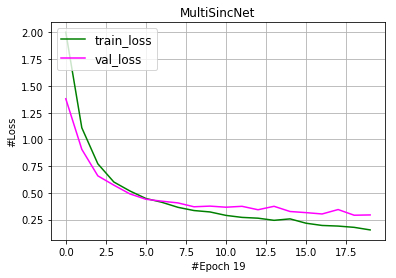

19	Training:
	Loss:	0.15378
	ACC:	0.94955
19	Validation:
	BEST VAL loss:	0.29121
	Loss:	0.29387
	ACC:	0.90608




In [45]:

for epoch in range(num_epochs):
    
    
    train_loss = train_acc = train_batches = 0 
    train_acc_fixed = 0
    model.train()
    y_true,y_pred = [],[]
    for batch in train_loader:
        
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        with torch.no_grad():
            train_loss += loss.item()
            train_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    
    with torch.no_grad():
        train_acc += compute_acc(y_true, y_pred).cpu().numpy()
    
    val_loss = val_acc = val_batches = 0
    val_acc_fixed = 0
    #model.train(False)
    model.eval()
    y_true,y_pred = [],[]
    for batch in val_loader:
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            val_loss += loss.item()
            
            val_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        val_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #val_acc = (val_acc / val_batches)
    
    val_loss = (val_loss / val_batches)
    if val_loss < best_loss:
        best_loss = val_loss
        if sPATH != '' and os.path.exists(sPATH):
            os.remove(sPATH)
        sPATH = fmt_str % (model.__class__.__name__,best_loss)
        torch.save(model.state_dict(),sPATH)
        if best_acc > 94:
            print("Early Stopping")
            break
    report['train_loss'].append(train_loss / train_batches)
    report['val_loss'].append(val_loss)
    
    display.clear_output(wait=True)
    fig = plt.Figure(figsize=(12,6),facecolor='white')
    plt.plot(report['train_loss'],color='green',label='train_loss')
    plt.plot(report['val_loss'],color='magenta',label='val_loss')
    plt.xlabel("#Epoch %d" % epoch)
    plt.ylabel("#Loss")
    plt.title(model.__class__.__name__)
    legend(loc=2, prop={'size': 12})
    plt.grid()
    plt.show()
    
    print("%d\tTraining:" % (epoch))
        
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tACC:\t%.5f" % (train_acc))
    print("%d\tValidation:" % (epoch))
    print("\tBEST VAL loss:\t%.5f" % best_loss)
    print("\tLoss:\t%.5f" % val_loss)
    print("\tACC:\t%.5f" % val_acc)
    print('\n')
    
    
    if epoch  % verbose == 0 or epoch == num_epochs - 1:
        pass

In [46]:
model.load_state_dict(torch.load(sPATH))
model.eval();

## Metrics

In [47]:
y_true_np = torch.argmax(y_true,dim=-1).detach().cpu().numpy()
y_pred_np = torch.argmax(y_pred.log_softmax(dim=-1),dim=-1).detach().cpu().numpy()

In [48]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [49]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.jet):
    plt.figure(figsize(20,20),facecolor='white')
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(model.__class__.__name__)
    colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name, fontsize=12)
    plt.xlabel(df_confusion.columns.name, fontsize=12)

In [50]:
def create_conf_matrix(y_true, y_pred, n_classes = num_classes):
    """
        src : https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
    """
    m = np.zeros([n_classes,n_classes],dtype=np.int32)
    for pred, exp in zip(y_pred,y_true):
        m[pred][exp] += 1
    return m

In [51]:
n_conf = 5 if demo_mode else num_classes + 1

In [52]:
if demo_mode:
    y_true_np,y_pred_np = y_true_np+1,y_pred_np+1 

In [56]:
creport = pd.DataFrame((classification_report(y_true_np,y_pred_np,output_dict=True)))

fm_score = []
for i in range(n_conf):
    try:
        fm_score.append(creport[str(i)]['f1-score'])
    except:
        pass

In [57]:
np.mean(fm_score )

0.9105440135508759

In [68]:
correct = [i for i,e in enumerate(cmdf.columns) if not str(e).isnumeric() ]

In [75]:
# rope jumping corrupting color scheme
cm  = create_conf_matrix(y_true_np,y_pred_np,n_classes=n_conf)
cmdf = pd.DataFrame(cm)
cols = [num2label[i] if i in list(num2label.keys()) else str(i) for i in range(n_conf)]
cmdf.columns = cols
cmdf.index = cols
cmdf = cmdf.iloc[correct ,correct ]
#if 'rope jumping' in cmdf.columns:
#    cmdf = cmdf.drop('rope jumping', 1)

In [76]:
cmdf 

,other,lying,sitting,standing,walking,running,cycling,Nordic walking,8,watching TV,computer work,car driving,ascending stairs,descending stairs,14,15,vacuum cleaning,ironing
other,419,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
lying,0,439,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sitting,0,2,386,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0
standing,0,0,0,474,1,0,2,0,0,0,0,0,0,0,0,0,0,0
walking,0,0,0,0,207,0,1,0,0,0,0,0,0,0,0,0,0,0
running,0,0,0,0,0,366,0,0,0,0,0,0,0,0,0,1,0,0
cycling,0,0,0,0,0,1,404,0,0,0,0,0,0,0,0,0,0,0
Nordic walking,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
watching TV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## History of best Results

#### Regular conv1DNet
all classes F_m : 0.9057730597984974
<br>
4 classes F_M   : 0.980124538692786

#### MultiSincNet
all classes F_m : 0.910066759618529
<br>
4 classes F_M   : 0.9838875053661083